In [1]:
import json
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

%load_ext autoreload
%autoreload 2
%aimport connectivity

base_path = "D:/data_paper"
patient_id = "EL027"
CLEAN_DATA_FILE = "out/clean_CR_IO/bad_responses_dict.json"
RESPONSES_FILE = "../publish_data/paper/significant_responses/response_channels_lf.json"
AVERAGE_FIRST_FILE = "../publish_data/paper/average_first_simple/average_first_results.json"
AUC_PATH = "../publish_data/paper/average_first"
n_replications = 12
allowed_ids = ["EL019", "EL020", "EL021", "EL022", "EL026", "EL027", "EL028"]
from matplotlib.gridspec import GridSpec

with open(AVERAGE_FIRST_FILE, "r") as f:
    average_first_results = json.load(f)
average_first_results = {k: v for k, v in average_first_results.items() if k in allowed_ids}

#### Panel A

In [2]:
# raw traces
from connectivity.analyze import calculate_stimulation_response_curves, filter_logs
from connectivity.enums import SleepStage
from connectivity.load import MultipleHDFResponseLoader, get_h5_names_of_patient

stim_channel_name_pos = "A-L-3"
stim_channel_name_neg = "A-L-4"
stim_channel_name = stim_channel_name_pos + "-" + stim_channel_name_neg

#response_channel_name_pos = "CinG-L-1"
#response_channel_name_pos = "pH-L-4"
#response_channel_name_pos = "aI-L-3"
response_channel_name_pos = "aH-L-3"
#response_channel_name_neg = "CinG-L-2"
#response_channel_name_neg = "pH-L-5"
#response_channel_name_neg = "aI-L-4"
response_channel_name_neg = "aH-L-4"

# stim ids:

response_channel_name = response_channel_name_pos + "-" + response_channel_name_neg


names_h5 = get_h5_names_of_patient(base_path, patient_id, protocol="CR", new_overview_format=True)
path_lookup = f"{base_path}/{patient_id}/Electrodes/Lookup.xlsx"
paths_h5 = [
    f"{base_path}/{patient_id}/Electrophy/{name}.h5" for name in names_h5
]
paths_logs = [
    f"{base_path}/{patient_id}/out/{name}_logs.csv" for name in names_h5
]
path_excluded_responses = f"{base_path}/{patient_id}/{CLEAN_DATA_FILE}"

mrl = MultipleHDFResponseLoader(
    paths_h5=paths_h5,
    paths_logs=paths_logs,
    recording_names=names_h5,
    path_lookup=path_lookup,
    path_excluded_responses=path_excluded_responses,
)
response_channel_path = mrl.get_channel_paths_from_names(channel_names=[response_channel_name])[0]
mrl.add_sleep_score_to_logs()
logs = mrl.get_logs()


io_stimlist = filter_logs(
    complete_logs=logs,
    n_replications=12,
    selected_stim_channel_name_pos=stim_channel_name_pos,
    selected_stim_channel_name_neg=stim_channel_name_neg,
    sleep_stages=[SleepStage.AWAKE, SleepStage.QWAKE],
)

io_intensities = (
    logs[logs["type"] == "CR_IO"]["Int_prob"].drop_duplicates().tolist()
)
io_intensities.sort()
io_intensities.insert(0, 0)
n_intensities = len(io_intensities)



response_channels_result = pd.read_json(RESPONSES_FILE, orient="records")
response_channels_result = response_channels_result[response_channels_result["patient_id"].isin(allowed_ids)]

df_row = response_channels_result[(response_channels_result["patient_id"] == patient_id) & (response_channels_result["stim_channel_name"] == stim_channel_name) & (response_channels_result["response_channel_name"] == response_channel_name)].iloc[0]
id_matrix = df_row["id_matrix"]
id_matrix = np.array(id_matrix) # shape: n_intensities, n_replications

def plot_panel_a(ax_b):
    ind_matrix = mrl.get_inds_from_stim_ids(id_matrix)

    ll_window_start = round(
        1 * mrl.f_sample
    )  # we only want to have the [0, 0.5s] window to display, as it is used for LL calculation
    ll_window_end = round(1.5 * mrl.f_sample)
    chunk_len = ll_window_end - ll_window_start  # traces.shape[3]
    total_chunks = id_matrix.shape[0]
    time = np.arange(chunk_len * total_chunks) / mrl.f_sample

    # Plot each chunk with color-coded significance
    for j in range(total_chunks):
        if j == 0:
            # for surrogate median, we don't have traces
            traces_chunk = np.full((n_replications, chunk_len), np.nan)  # shape: n_replications, n_time
        else:
            traces = mrl.get_responses(
                stim_indices=ind_matrix[j],
                response_channel_paths=[response_channel_path],
                # overwrite_excluded_recordings=exclude_responses,
                t_start=-1,
                t_stop=1,
                overwrite_excluded_recordings=True,  # TODO do we want this?
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time, remove middle dim
            traces_chunk = traces[:, ll_window_start:ll_window_end]
           
        avg_trace_chunk = np.nanmean(traces_chunk, axis=0)  # shape: n_time

        start_idx = j * chunk_len
        end_idx = (j + 1) * chunk_len
        time_chunk = time[start_idx:end_idx]

        for trace in traces_chunk:
            ax_b.plot(time_chunk, trace, color="black", alpha=0.1, linewidth=0.5)
        ax_b.plot(
            time_chunk,
            avg_trace_chunk,
            color="black",
            linewidth=0.75,
        )

        start = start_idx / mrl.f_sample
        end = end_idx / mrl.f_sample
        ax_b.axvspan(
            start,
            end,
            facecolor=("lightgray" if j % 2 else "white"),
            alpha=0.3,
            zorder=0,
        )
    ax_b.set_ylabel("EEG $\\left[\\mu \\mathrm{V}\\right]$")
    ax_b.margins(x=0, y=0)
    ax_b.set_xlabel("Stitched time [s]")
    #ax_b.set_xticks([])

### Panel B

In [3]:
from connectivity.analyze import calculate_continuous_line_length


def plot_panel_b(ax_b):
    ind_matrix = mrl.get_inds_from_stim_ids(id_matrix)

    ll_window_start = round(
        1 * mrl.f_sample
    )  # we only want to have the [0, 0.5s] window to display, as it is used for LL calculation
    ll_max_window_offset = round(0.25 * mrl.f_sample) # max is taken from [0.25, 5s]
    ll_window_end = round(1.5 * mrl.f_sample)
    chunk_len = ll_window_end - ll_window_start  # traces.shape[3]
    total_chunks = id_matrix.shape[0]
    time = np.arange(chunk_len * total_chunks) / mrl.f_sample

    # Plot each chunk with color-coded significance
    for j in range(total_chunks):
        if j == 0:
            # for surrogate median, we don't have traces
            cont_ll = np.full((n_replications, chunk_len), np.nan)  # shape: n_replications, n_time
            cont_ll_avg = np.full((chunk_len,), np.nan)
        else:
            traces = mrl.get_responses(
                stim_indices=ind_matrix[j],
                response_channel_paths=[response_channel_path],
                # overwrite_excluded_recordings=exclude_responses,
                t_start=-1,
                t_stop=1,
                overwrite_excluded_recordings=True,  # TODO do we want this?
            ).squeeze(
                1
            )  # shape: n_replications, 1, n_time, remove middle dim
            avg_trace = np.nanmean(traces, axis=0)  # shape: n_time

            cont_ll = calculate_continuous_line_length(
                data=traces,
                start_index=ll_window_start,
                end_index=ll_window_end,
                window_width_indices=round(0.25 * mrl.f_sample),
                f_sample=mrl.f_sample,
            )
            cont_ll_avg = calculate_continuous_line_length(
                data=avg_trace,
                start_index=ll_window_start,
                end_index=ll_window_end,
                window_width_indices=round(0.25 * mrl.f_sample),
                f_sample=mrl.f_sample,
            )


        #avg_trace_chunk = np.nanmean(traces_chunk, axis=0)  # shape: n_time

        start_idx = j * chunk_len
        end_idx = (j + 1) * chunk_len
        time_chunk = time[start_idx:end_idx]

        for trace in cont_ll:
            ax_b.plot(time_chunk, trace, color="black", alpha=0.1, linewidth=0.5)

            max_idx = (
                        trace[ll_max_window_offset:].argmax() + ll_max_window_offset
                    )
            ax_b.scatter(time_chunk[max_idx], trace[max_idx], color='purple', s=10)
        
        max_idx = cont_ll_avg.argmax()
        ax_b.scatter(time_chunk[max_idx], cont_ll_avg[max_idx], color='blue', s=10)
        ax_b.plot(
            time_chunk,
            cont_ll_avg,
            color="black",
            linewidth=0.75,
        )

        start = start_idx / mrl.f_sample
        end = end_idx / mrl.f_sample
        ax_b.axvspan(
            start,
            end,
            facecolor=("lightgray" if j % 2 else "white"),
            alpha=0.3,
            zorder=0,
        )
    ax_b.set_ylabel("LL $\\left[\\frac{\\Delta\\mu \\mathrm{V}}{\\mathrm{ms}}\\right]$")
    ax_b.margins(x=0, y=0)
    #ax_b.set_xlabel("Time [s]")
    #ax_b.set_xticks([])

In [4]:
# single response (for stacked)

# FIXME remove this add add ll value to average_first result json.
from connectivity.analyze import calculate_pointwise_line_length_max


# ll_values, ll_values_avg_first, traces, _ = calculate_stimulation_response_curves(
#     stimlist=io_stimlist,
#     response_loader=mrl,
#     selected_stim_channel_name_pos=stim_channel_name_pos,
#     selected_stim_channel_name_neg=stim_channel_name_neg,
#     selected_channel_paths=[response_channel_path],
#     selected_intensities=io_intensities,
#     # average_only=True,
#     old_triplets=True if patient_id == "EL019" else False,
#     exclude_responses=True,
# )
# ll_values = ll_values.squeeze(2)  # shape: n_intensities, n_replications
# ll_values_avg_first = ll_values_avg_first.squeeze(1)  # shape: n_intensities
# #id_matrix = id_matrix.squeeze(2)  # shape: n_intensities, n_replications
# traces = traces.squeeze(2)  # shape: n_intensities, n_replications, n_time

ind_matrix = mrl.get_inds_from_stim_ids(id_matrix[1:])
traces = []
for row in ind_matrix:
    data = mrl.get_responses(
        stim_indices=row,
        response_channel_paths=[response_channel_path],
        # overwrite_excluded_recordings=exclude_responses,
        t_start=-1,
        t_stop=1,
        overwrite_excluded_recordings=True,  # TODO do we want this?
    ).squeeze(1) # shape: (n_rep, n_time)
    traces.append(data)
traces = np.array(traces)

zero_trace = np.zeros_like(traces[0])[np.newaxis, ...]
traces = np.concatenate((zero_trace, traces), axis=0)

avg_traces = np.nanmean(traces, axis=1)
ll_avg_first = calculate_pointwise_line_length_max(avg_traces, offset_stim_seconds=1, f_sample=mrl.f_sample)
ll_values = calculate_pointwise_line_length_max(traces, offset_stim_seconds=1, f_sample=mrl.f_sample)
#print(json.dumps(ll_values.tolist(), indent=4))
ll_ll_first = np.nanmedian(ll_values, axis=1)

# FIXME replace 

def plot_single_response_avg_first(
    ax,
    traces
):
    time = np.arange(traces.shape[1]) / mrl.f_sample - 1
    ax.plot(
        time,
        np.nanmean(traces, axis=0).squeeze(),
        color="black",
        linewidth=0.5,
    )
    #ax.set_ylabel("EEG [uV]")
    #ax.set_xlabel("Time [s]")
    ax.axis('off')
    
    ax.set_xlim([-0.25, 0.75])
    ax.axvline(0, color="yellow", linewidth=0.5)
    ax.axvspan(0, 0.5, facecolor="lightgray", alpha=0.5, zorder=0)
    ax.margins(x=0, y=0)
    for trace in traces:
        ax.plot(time, trace.squeeze(), color="black", alpha=0.5, linewidth=0.25)

def plot_single_response_ll_first(
    ax,
    traces
):
    time = np.arange(traces.shape[1]) / mrl.f_sample - 1
    #ax.set_ylabel("EEG [uV]")
    #ax.set_xlabel("Time [s]")
    ax.axis('off')
    ax.margins(x=0, y=0)
    ax.set_xlim([-0.25, 0.75])
    ax.axvline(0, color="yellow", linewidth=0.5)
    ax.axvspan(0, 0.5, facecolor="lightgray", alpha=0.5, zorder=0)
    ax.margins(x=0, y=0)
    for trace in traces:
        ax.plot(time, trace.squeeze(), color="black", linewidth=0.5)


In [5]:
# stimulation response curve
from connectivity.analyze import calculate_pointwise_line_length_max

def plot_stimulation_response_curve_avg_first(
    ax,
    intensities,
    ll_values,
    
):
    ax.scatter(intensities, ll_values, color="black", s=10, label="LL")
    ax.plot(
        intensities,
        ll_values,
        color="blue",
        linewidth=1,
    )
    #ax.set_ylabel("LL $\\left[\\frac{\\Delta\\mu \\mathrm{V}}{\\mathrm{ms}}\\right]$")
    ax.set_xlabel("Intensity [mA]")
    ax.set_title("Average-first")

def plot_stimulation_response_curve_ll_first(
    ax,
    intensities,
    ll_values,
    
):
    for j in range(ll_values.shape[1]):
        ax.scatter(intensities, ll_values[:, j], color="black", s=10, label="LL")
    ax.plot(
        intensities,
        np.nanmedian(ll_values, axis=1),
        color="purple",
        linewidth=1,
    )
    ax.set_ylabel("LL $\\left[\\frac{\\Delta\\mu \\mathrm{V}}{\\mathrm{ms}}\\right]$")
    ax.set_xlabel("Intensity [mA]")
    ax.set_title("Magnitude-first")



In [6]:
# Normalized

from connectivity.analyze import normalize_ll_values

def plot_stimulation_response_curve_norm(
    ax,
    intensities,
    ll_first,
    avg_first
):
    ax.plot(
        intensities,
        ll_first,
        color="purple",
        linewidth=1,
        label="Magnitude-first",
    )
    ax.plot(
        intensities,
        avg_first,
        color="blue",
        linewidth=1,
        label="Average-first",
    )
    ax.legend()
    ax.set_ylabel("Normalized LL [a.u.]")
    ax.set_xlabel("Norm. intensity [a.u.]")
    ax.set_title("Normalized")

norm_intensities = np.array(io_intensities) / np.max(io_intensities)

norm_ll_ll_first = normalize_ll_values(ll_values=ll_ll_first, axis=0)
norm_ll_avg_first = normalize_ll_values(ll_values=ll_avg_first, axis=0)


def plot_panel_e(ax):
    plot_stimulation_response_curve_norm(
        ax,
        norm_intensities[1:],
        norm_ll_ll_first[1:],
        norm_ll_avg_first[1:],
    )


#### Panel F

In [75]:
import seaborn as sns
from statannotations.Annotator import Annotator
import pandas as pd
import matplotlib.lines as mlines

#metrics = [["aucs_ll_first_mean", "aucs_avg_first_mean"], ["aucs_ll_first_std", "aucs_avg_first_std"], ["aucs_ll_first_median", "aucs_avg_first_median"], ["cvs_ll_first", "cvs_avg_first"]]
agg_results = {}
pat_results = {}
rows_agg = []
rows = []
# plot_pairs = []
p_values = []

test_p = []

for patient_id, patient_result in average_first_results.items():
    for stim_channel_name, stim_channel_result in patient_result.items():
        if len(stim_channel_result["exis_ll_first"]) == 0:
            # TODO where are they coming from?
            print(f"Skipping {patient_id} {stim_channel_name} as no results found")
            continue
        #n_values = len(stim_channel_result["response_channel_paths"])


        exis_ll_first = []
        exis_avg_first = []
        for i_resp, resp_channel_path in enumerate(stim_channel_result["response_channel_paths"]):
            resp_channel_name = resp_channel_path.split("/")[-1]

            response_res = response_channels_result[(response_channels_result["patient_id"] == patient_id) & (response_channels_result["stim_channel_name"]==stim_channel_name) & (response_channels_result["response_channel_name"] == resp_channel_name)].squeeze()
            if response_res["is_significant"]:
                exis_ll_first.append(stim_channel_result["exis_ll_first"][i_resp])
                exis_avg_first.append(stim_channel_result["exis_avg_first"][i_resp])
        
        n_values = len(exis_ll_first)
        rows_agg.extend([
            {
                "patient_id": patient_id,
                "stim_channel_name": stim_channel_name,
                "exis_ll_first": exis_ll_first[k],
                "exis_avg_first": exis_avg_first[k]
            }
            for k in range(n_values)
        ])
   

df_agg = pd.DataFrame(rows_agg)
df = pd.DataFrame(rows)



#, p_mean = scipy.stats.wilcoxon(agg_results["aucs_ll_first_mean"], agg_results["aucs_avg_first_mean"])


def plot_panel_f(ax):
    #restricted_metrics = df[df["metric"].isin(["aucs_ll_first_mean", "aucs_avg_first_mean"])].copy()
    #restricted_metrics.loc[restricted_metrics["metric"] == "aucs_ll_first_mean", "metric"] = "LL-first"
    #restricted_metrics.loc[restricted_metrics["metric"] == "aucs_avg_first_mean", "metric"] = "Avg-first"
    restricted_metrics = df_agg # [(df_agg["exis_ll_first"] < 2) & (df_agg["exis_avg_first"] < 2)]
    
    #_, p_mean = scipy.stats.wilcoxon(restricted_metrics["auc_ll"], restricted_metrics["auc_avg"])

    # bring to long form
    df_melted = restricted_metrics.melt(
        id_vars=["patient_id"], 
        value_vars=["exis_ll_first", "exis_avg_first"], 
        var_name="metric", 
        value_name="value"
    )
    df_melted.loc[df_melted["metric"] == "exis_ll_first", "metric"] = "Magnitude-first"
    df_melted.loc[df_melted["metric"] == "exis_avg_first", "metric"] = "Average-first"
    

    sns.violinplot(data=df_melted, x="patient_id", y="value", hue="metric",
        split=True, palette={"Magnitude-first": "purple", "Average-first": "blue"}, ax=ax, inner=None)
    ax.set_ylim([-0.2, 1.4])

    # Compute medians per patient & metric
    medians = df_melted.groupby(["patient_id", "metric"])["value"].median()
    for i, patient in enumerate(df_melted["patient_id"].unique()):
        for j, metric in enumerate(["Magnitude-first", "Average-first"]):
            median = medians.loc[patient, metric]
            if metric == "Magnitude-first":
                x0, x1 = i - 0.4, i
                color = "white"
            else:
                x0, x1 = i, i + 0.4
                color = "white"
            ax.hlines(median, x0, x1, color=color, linewidth=1)

    #ax.legend(title="", loc="upper right")
    ax.set_title("")
    ax.set_ylabel("ExI [a.u.]")
    ax.set_xlabel("")


    for i, (patient_id, _) in enumerate(average_first_results.items()):
        n_values = len(restricted_metrics.loc[restricted_metrics["patient_id"] == patient_id])
        _, p = scipy.stats.wilcoxon(restricted_metrics.loc[restricted_metrics["patient_id"] == patient_id, "exis_ll_first"], restricted_metrics.loc[restricted_metrics["patient_id"] == patient_id, "exis_avg_first"])

        # Format p-value to stars
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = 'ns'

        # X-axis positions (split violin around x=i)
        x1, x2 = i - 0.15, i + 0.15
        y_min = 0.12
        y = y_min  # below the bottom of the violin
        h = 0.05         # height of line

        # Draw line and text
        ax.plot([x1, x1, x2, x2], [y, y-h, y-h, y], lw=1.2, c='k')
        sig += f"\nn={n_values}"
        ax.text((x1 + x2) / 2, y - h - 0.02, sig, ha='center', va='top', fontsize=8)

    # Existing legend handles + labels
    handles, labels = ax.get_legend_handles_labels()

    # Dummy entries for significance
    star1 = mlines.Line2D([], [], color='none', label='*: p < 0.05')
    star2 = mlines.Line2D([], [], color='none', label='**: p < 0.01')
    star3 = mlines.Line2D([], [], color='none', label='***: p < 0.001')
    star4 = mlines.Line2D([], [], color='none', label='ns: not significant')

    # Combine both
    handles += [star1, star2, star3, star4]
    labels  += [h.get_label() for h in [star1, star2, star3, star4]]

    # Create legend, horizontal layout
    ax.legend(handles, labels, title="", loc="upper right", ncol=3, fontsize=8)

    # annotator = Annotator(ax, plot_pairs, data=restricted_metrics, x="patient_id", y="value", hue="metric")
    # annotator.set_pvalues_and_annotate(pvalues=p_values)

Skipping EL026 OFC-L-1-OFC-L-2 as no results found


In [8]:
def plot_panel_g(ax):
    #restricted_metrics = df[df["metric"].isin(["aucs_ll_first_mean", "aucs_avg_first_mean"])].copy()
    #restricted_metrics.loc[restricted_metrics["metric"] == "aucs_ll_first_mean", "metric"] = "LL-first"
    #restricted_metrics.loc[restricted_metrics["metric"] == "aucs_avg_first_mean", "metric"] = "Avg-first"
    restricted_metrics = df_agg # [(df_agg["exis_ll_first"] < 2) & (df_agg["exis_avg_first"] < 2)]
    
    #_, p_mean = scipy.stats.wilcoxon(restricted_metrics["auc_ll"], restricted_metrics["auc_avg"])

    # bring to long form
    # Compute the difference before melting
    restricted_metrics["Difference"] = restricted_metrics["exis_ll_first"] - restricted_metrics["exis_avg_first"]

    # Now melt only the difference column if you want to keep consistent structure
    df_diff = restricted_metrics[["patient_id", "Difference"]]

    # Plot the difference as a single violin per patient
    sns.violinplot(data=df_diff, x="patient_id", y="Difference", ax=ax, inner=None)

    medians = df_diff.groupby("patient_id")["Difference"].median()

    # Overlay medians as black horizontal lines
    for i, (patient, median) in enumerate(medians.items()):
        ax.hlines(median, i - 0.4, i + 0.4, color="white", linewidth=1)

    ax.axhline(0, color="black", linewidth=0.5, linestyle="--")
    ax.set_title("")
    ax.set_ylabel("ExI difference [a.u.]")
    ax.set_xlabel("")


In [68]:
def plot_panel_h(ax):
    markers = ["o", "s", "D", "^", "v", "<", ">"]  

    for i, patient_id in enumerate(allowed_ids):
        df_pat = df_agg[df_agg["patient_id"] == patient_id]

        # Pick a marker based on index
        marker = markers[i % len(markers)]

        ax.scatter(
            (df_pat["exis_ll_first"] + df_pat["exis_avg_first"]) / 2,
            df_pat["exis_ll_first"] - df_pat["exis_avg_first"],
            alpha=0.50,
            s=10,
            marker=marker,
            label=f"{patient_id}"
        )

        comparison = df_pat["exis_ll_first"] > df_pat["exis_avg_first"]
        # print(
        #     f"{patient_id}: Mag-first bigger: {np.sum(comparison)}/"
        #     f"Avg-first bigger: {len(df_pat) - np.sum(comparison)} | "
        #     f"Total: {len(comparison)} | "
        #     f"Median Mag-first: {np.median(df_pat['exis_ll_first']):.2f},  "
        #     f"Median avg-first: {np.median(df_pat['exis_avg_first']):.2f}"
        # )

    # Compute overall bias and limits
    diff = df_agg["exis_ll_first"] - df_agg["exis_avg_first"]
    diff_mean = np.mean(diff)

    print("Diff. mean across participants: ", diff_mean)
    diff_std = np.std(diff, ddof=1)


    ax.axhline(diff_mean + diff_std, color="gray", linestyle="--", label="mean $\\pm$ std difference")
    ax.axhline(diff_mean, color="black", linestyle="-", label="mean difference")
    ax.axhline(diff_mean - diff_std, color="gray", linestyle="--")
    ax.set_title(f"Bland-Altman\nMean difference (Magnitude-first - Average-first) = {diff_mean:.3f}")
    ax.set_xlabel("Mean of methods")
    ax.set_ylabel("Difference of methods\n(Magnitude-first - Average-first)")
    ax.legend(ncols = 3, fontsize=8)


C:\Users\E1024679\AppData\Local\Temp\ipykernel_17632\1779373689.py:99: RuntimeWarning: Mean of empty slice
  avg_trace_chunk = np.nanmean(traces_chunk, axis=0)  # shape: n_time


Diff. mean across participants:  -0.005645155089669025


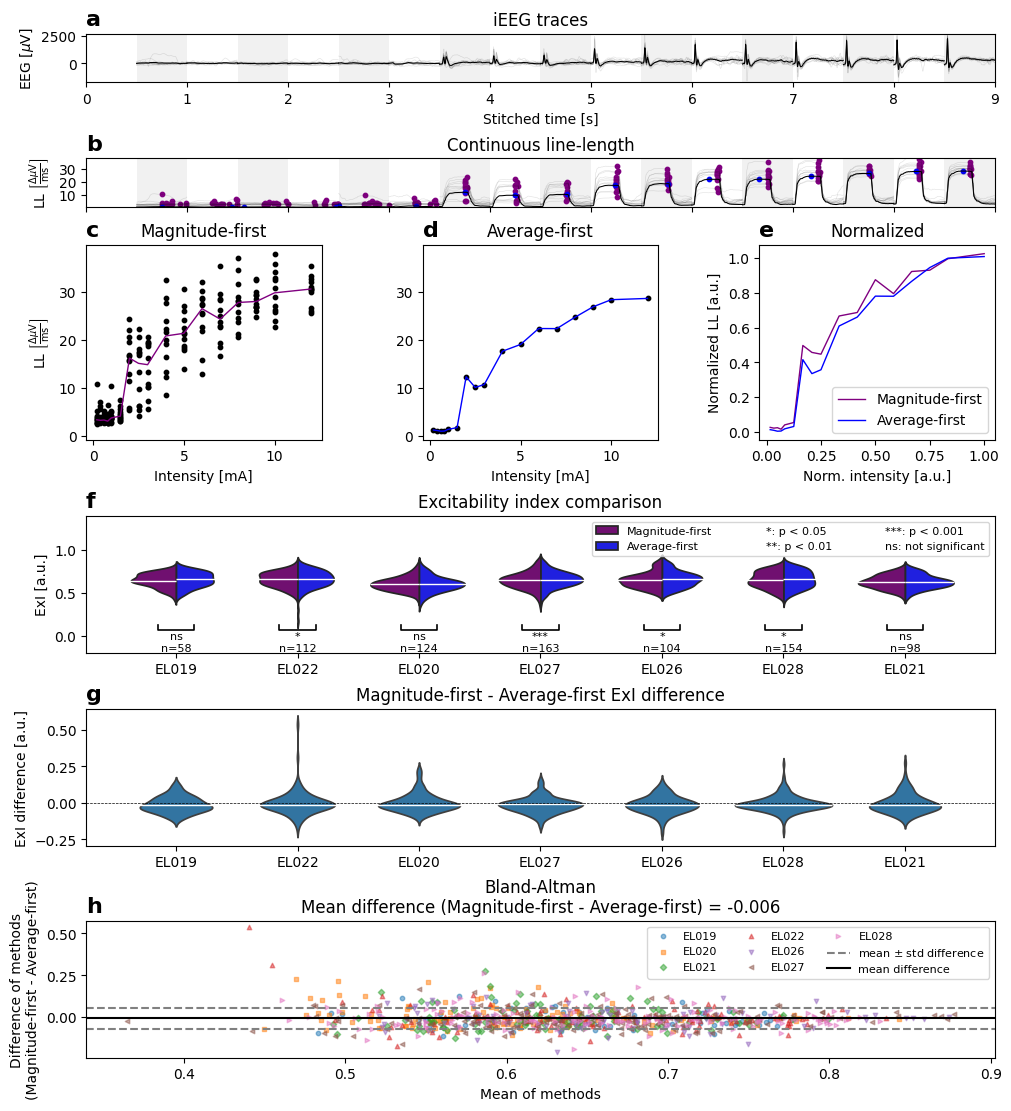

In [77]:
fig = plt.figure(figsize=(10, 11), constrained_layout=True)
gs = GridSpec(6, 3, figure=fig, width_ratios=[1, 1, 1], height_ratios=[0.5, 0.5, 2, 1.4, 1.4, 1.4])

ax_a = fig.add_subplot(gs[0, :])
ax_a.set_title("iEEG traces")
plot_panel_a(ax_a)
ax_a.set_title("a", loc='left', fontsize=16, fontweight='bold')

ax_b = fig.add_subplot(gs[1, :], sharex=ax_a)
ax_b.set_title("Continuous line-length")
plot_panel_b(ax_b)
ax_b.set_title("b", loc='left', fontsize=16, fontweight='bold')
plt.setp(ax_b.get_xticklabels(), visible=False)

ax_c = fig.add_subplot(gs[2, 0])
plot_stimulation_response_curve_ll_first(ax_c, io_intensities[1:], ll_values[1:])
ax_c.set_title("c", loc='left', fontsize=16, fontweight='bold')

ax_d = fig.add_subplot(gs[2, 1], sharey=ax_c)
plot_stimulation_response_curve_avg_first(ax_d, io_intensities[1:], ll_avg_first[1:])
ax_d.set_title("d", loc='left', fontsize=16, fontweight='bold')

ax_e = fig.add_subplot(gs[2, 2])
plot_panel_e(ax_e)
ax_e.set_title("e", loc='left', fontsize=16, fontweight='bold')


ax_f = fig.add_subplot(gs[3, :])
plot_panel_f(ax_f)
ax_f.set_title("Excitability index comparison")
ax_f.set_title("f", loc='left', fontsize=16, fontweight='bold')

ax_g = fig.add_subplot(gs[4, :])
plot_panel_g(ax_g)
ax_g.set_title("Magnitude-first - Average-first ExI difference")
ax_g.set_title("g", loc='left', fontsize=16, fontweight='bold')

ax_h = fig.add_subplot(gs[5, :])
plot_panel_h(ax_h)
ax_h.set_title("h", loc='left', fontsize=16, fontweight='bold')

plt.savefig("../output/figures/sfigure1.pdf", bbox_inches='tight', dpi=300)
plt.savefig("../output/figures/sfigure1.svg", bbox_inches='tight', dpi=300)
plt.show()

# ids:

                    "id_matrix": [
                        [
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median",
                            "Surrogate median"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-611",
                            "EL027_20230822_19h19m21_CR/CR_IO-621",
                            "EL027_20230822_19h19m21_CR/CR_IO-665",
                            "EL027_20230822_19h19m21_CR/CR_IO-1234",
                            "EL027_20230822_21h04m31_CR/CR_IO-123",
                            "EL027_20230822_21h04m31_CR/CR_IO-656",
                            "EL027_20230822_21h04m31_CR/CR_IO-690",
                            "EL027_20230822_21h04m31_CR/CR_IO-746",
                            "EL027_20230822_21h04m31_CR/CR_IO-1442",
                            "EL027_20230822_21h04m31_CR/CR_IO-1470",
                            "EL027_20230822_21h04m31_CR/CR_IO-1544",
                            "EL027_20230822_21h04m31_CR/CR_IO-2083"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-573",
                            "EL027_20230822_19h19m21_CR/CR_IO-668",
                            "EL027_20230822_19h19m21_CR/CR_IO-682",
                            "EL027_20230822_19h19m21_CR/CR_IO-1255",
                            "EL027_20230822_21h04m31_CR/CR_IO-11",
                            "EL027_20230822_21h04m31_CR/CR_IO-141",
                            "EL027_20230822_21h04m31_CR/CR_IO-653",
                            "EL027_20230822_21h04m31_CR/CR_IO-659",
                            "EL027_20230822_21h04m31_CR/CR_IO-717",
                            "EL027_20230822_21h04m31_CR/CR_IO-1365",
                            "EL027_20230822_21h04m31_CR/CR_IO-1372",
                            "EL027_20230822_21h04m31_CR/CR_IO-1430"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-677",
                            "EL027_20230822_19h19m21_CR/CR_IO-694",
                            "EL027_20230822_19h19m21_CR/CR_IO-716",
                            "EL027_20230822_19h19m21_CR/CR_IO-1243",
                            "EL027_20230822_21h04m31_CR/CR_IO-29",
                            "EL027_20230822_21h04m31_CR/CR_IO-102",
                            "EL027_20230822_21h04m31_CR/CR_IO-684",
                            "EL027_20230822_21h04m31_CR/CR_IO-689",
                            "EL027_20230822_21h04m31_CR/CR_IO-757",
                            "EL027_20230822_21h04m31_CR/CR_IO-1360",
                            "EL027_20230822_21h04m31_CR/CR_IO-1510",
                            "EL027_20230822_21h04m31_CR/CR_IO-1551"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-584",
                            "EL027_20230822_19h19m21_CR/CR_IO-587",
                            "EL027_20230822_19h19m21_CR/CR_IO-699",
                            "EL027_20230822_21h04m31_CR/CR_IO-30",
                            "EL027_20230822_21h04m31_CR/CR_IO-135",
                            "EL027_20230822_21h04m31_CR/CR_IO-693",
                            "EL027_20230822_21h04m31_CR/CR_IO-748",
                            "EL027_20230822_21h04m31_CR/CR_IO-786",
                            "EL027_20230822_21h04m31_CR/CR_IO-1421",
                            "EL027_20230822_21h04m31_CR/CR_IO-1453",
                            "EL027_20230822_21h04m31_CR/CR_IO-1479",
                            "EL027_20230822_21h04m31_CR/CR_IO-2200"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-630",
                            "EL027_20230822_19h19m21_CR/CR_IO-635",
                            "EL027_20230822_19h19m21_CR/CR_IO-636",
                            "EL027_20230822_19h19m21_CR/CR_IO-1239",
                            "EL027_20230822_21h04m31_CR/CR_IO-21",
                            "EL027_20230822_21h04m31_CR/CR_IO-60",
                            "EL027_20230822_21h04m31_CR/CR_IO-765",
                            "EL027_20230822_21h04m31_CR/CR_IO-784",
                            "EL027_20230822_21h04m31_CR/CR_IO-811",
                            "EL027_20230822_21h04m31_CR/CR_IO-1445",
                            "EL027_20230822_21h04m31_CR/CR_IO-1500",
                            "EL027_20230822_21h04m31_CR/CR_IO-1502"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-526",
                            "EL027_20230822_19h19m21_CR/CR_IO-529",
                            "EL027_20230822_19h19m21_CR/CR_IO-599",
                            "EL027_20230822_19h19m21_CR/CR_IO-1227",
                            "EL027_20230822_21h04m31_CR/CR_IO-14",
                            "EL027_20230822_21h04m31_CR/CR_IO-93",
                            "EL027_20230822_21h04m31_CR/CR_IO-648",
                            "EL027_20230822_21h04m31_CR/CR_IO-676",
                            "EL027_20230822_21h04m31_CR/CR_IO-679",
                            "EL027_20230822_21h04m31_CR/CR_IO-1355",
                            "EL027_20230822_21h04m31_CR/CR_IO-1408",
                            "EL027_20230822_21h04m31_CR/CR_IO-1438"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-524",
                            "EL027_20230822_19h19m21_CR/CR_IO-576",
                            "EL027_20230822_19h19m21_CR/CR_IO-583",
                            "EL027_20230822_19h19m21_CR/CR_IO-1251",
                            "EL027_20230822_19h19m21_CR/CR_IO-1264",
                            "EL027_20230822_21h04m31_CR/CR_IO-115",
                            "EL027_20230822_21h04m31_CR/CR_IO-668",
                            "EL027_20230822_21h04m31_CR/CR_IO-760",
                            "EL027_20230822_21h04m31_CR/CR_IO-767",
                            "EL027_20230822_21h04m31_CR/CR_IO-1411",
                            "EL027_20230822_21h04m31_CR/CR_IO-1477",
                            "EL027_20230822_21h04m31_CR/CR_IO-1521"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-586",
                            "EL027_20230822_19h19m21_CR/CR_IO-663",
                            "EL027_20230822_19h19m21_CR/CR_IO-724",
                            "EL027_20230822_21h04m31_CR/CR_IO-3",
                            "EL027_20230822_21h04m31_CR/CR_IO-75",
                            "EL027_20230822_21h04m31_CR/CR_IO-100",
                            "EL027_20230822_21h04m31_CR/CR_IO-809",
                            "EL027_20230822_21h04m31_CR/CR_IO-825",
                            "EL027_20230822_21h04m31_CR/CR_IO-840",
                            "EL027_20230822_21h04m31_CR/CR_IO-1443",
                            "EL027_20230822_21h04m31_CR/CR_IO-1527",
                            "EL027_20230822_21h04m31_CR/CR_IO-1539"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-646",
                            "EL027_20230822_19h19m21_CR/CR_IO-658",
                            "EL027_20230822_19h19m21_CR/CR_IO-667",
                            "EL027_20230822_19h19m21_CR/CR_IO-1274",
                            "EL027_20230822_21h04m31_CR/CR_IO-27",
                            "EL027_20230822_21h04m31_CR/CR_IO-71",
                            "EL027_20230822_21h04m31_CR/CR_IO-670",
                            "EL027_20230822_21h04m31_CR/CR_IO-672",
                            "EL027_20230822_21h04m31_CR/CR_IO-704",
                            "EL027_20230822_21h04m31_CR/CR_IO-1416",
                            "EL027_20230822_21h04m31_CR/CR_IO-1424",
                            "EL027_20230822_21h04m31_CR/CR_IO-1531"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-555",
                            "EL027_20230822_19h19m21_CR/CR_IO-609",
                            "EL027_20230822_19h19m21_CR/CR_IO-695",
                            "EL027_20230822_21h04m31_CR/CR_IO-24",
                            "EL027_20230822_21h04m31_CR/CR_IO-77",
                            "EL027_20230822_21h04m31_CR/CR_IO-134",
                            "EL027_20230822_21h04m31_CR/CR_IO-666",
                            "EL027_20230822_21h04m31_CR/CR_IO-814",
                            "EL027_20230822_21h04m31_CR/CR_IO-817",
                            "EL027_20230822_21h04m31_CR/CR_IO-1393",
                            "EL027_20230822_21h04m31_CR/CR_IO-1432",
                            "EL027_20230822_21h04m31_CR/CR_IO-1464"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-642",
                            "EL027_20230822_19h19m21_CR/CR_IO-662",
                            "EL027_20230822_19h19m21_CR/CR_IO-679",
                            "EL027_20230822_19h19m21_CR/CR_IO-1278",
                            "EL027_20230822_21h04m31_CR/CR_IO-9",
                            "EL027_20230822_21h04m31_CR/CR_IO-13",
                            "EL027_20230822_21h04m31_CR/CR_IO-756",
                            "EL027_20230822_21h04m31_CR/CR_IO-824",
                            "EL027_20230822_21h04m31_CR/CR_IO-830",
                            "EL027_20230822_21h04m31_CR/CR_IO-1395",
                            "EL027_20230822_21h04m31_CR/CR_IO-1490",
                            "EL027_20230822_21h04m31_CR/CR_IO-1506"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-532",
                            "EL027_20230822_19h19m21_CR/CR_IO-552",
                            "EL027_20230822_19h19m21_CR/CR_IO-570",
                            "EL027_20230822_19h19m21_CR/CR_IO-1228",
                            "EL027_20230822_21h04m31_CR/CR_IO-105",
                            "EL027_20230822_21h04m31_CR/CR_IO-121",
                            "EL027_20230822_21h04m31_CR/CR_IO-645",
                            "EL027_20230822_21h04m31_CR/CR_IO-796",
                            "EL027_20230822_21h04m31_CR/CR_IO-829",
                            "EL027_20230822_21h04m31_CR/CR_IO-1349",
                            "EL027_20230822_21h04m31_CR/CR_IO-1369",
                            "EL027_20230822_21h04m31_CR/CR_IO-1410"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-588",
                            "EL027_20230822_19h19m21_CR/CR_IO-704",
                            "EL027_20230822_19h19m21_CR/CR_IO-706",
                            "EL027_20230822_19h19m21_CR/CR_IO-1257",
                            "EL027_20230822_21h04m31_CR/CR_IO-43",
                            "EL027_20230822_21h04m31_CR/CR_IO-98",
                            "EL027_20230822_21h04m31_CR/CR_IO-652",
                            "EL027_20230822_21h04m31_CR/CR_IO-696",
                            "EL027_20230822_21h04m31_CR/CR_IO-711",
                            "EL027_20230822_21h04m31_CR/CR_IO-1399",
                            "EL027_20230822_21h04m31_CR/CR_IO-1457",
                            "EL027_20230822_21h04m31_CR/CR_IO-1522"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-604",
                            "EL027_20230822_19h19m21_CR/CR_IO-709",
                            "EL027_20230822_19h19m21_CR/CR_IO-717",
                            "EL027_20230822_21h04m31_CR/CR_IO-31",
                            "EL027_20230822_21h04m31_CR/CR_IO-35",
                            "EL027_20230822_21h04m31_CR/CR_IO-99",
                            "EL027_20230822_21h04m31_CR/CR_IO-724",
                            "EL027_20230822_21h04m31_CR/CR_IO-816",
                            "EL027_20230822_21h04m31_CR/CR_IO-828",
                            "EL027_20230822_21h04m31_CR/CR_IO-1391",
                            "EL027_20230822_21h04m31_CR/CR_IO-1480",
                            "EL027_20230822_21h04m31_CR/CR_IO-1511"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-648",
                            "EL027_20230822_19h19m21_CR/CR_IO-653",
                            "EL027_20230822_19h19m21_CR/CR_IO-701",
                            "EL027_20230822_19h19m21_CR/CR_IO-1242",
                            "EL027_20230822_21h04m31_CR/CR_IO-20",
                            "EL027_20230822_21h04m31_CR/CR_IO-137",
                            "EL027_20230822_21h04m31_CR/CR_IO-726",
                            "EL027_20230822_21h04m31_CR/CR_IO-774",
                            "EL027_20230822_21h04m31_CR/CR_IO-795",
                            "EL027_20230822_21h04m31_CR/CR_IO-1361",
                            "EL027_20230822_21h04m31_CR/CR_IO-1366",
                            "EL027_20230822_21h04m31_CR/CR_IO-1543"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-545",
                            "EL027_20230822_19h19m21_CR/CR_IO-563",
                            "EL027_20230822_19h19m21_CR/CR_IO-640",
                            "EL027_20230822_21h04m31_CR/CR_IO-41",
                            "EL027_20230822_21h04m31_CR/CR_IO-70",
                            "EL027_20230822_21h04m31_CR/CR_IO-124",
                            "EL027_20230822_21h04m31_CR/CR_IO-644",
                            "EL027_20230822_21h04m31_CR/CR_IO-700",
                            "EL027_20230822_21h04m31_CR/CR_IO-842",
                            "EL027_20230822_21h04m31_CR/CR_IO-1350",
                            "EL027_20230822_21h04m31_CR/CR_IO-1380",
                            "EL027_20230822_21h04m31_CR/CR_IO-1439"
                        ],
                        [
                            "EL027_20230822_19h19m21_CR/CR_IO-603",
                            "EL027_20230822_19h19m21_CR/CR_IO-641",
                            "EL027_20230822_19h19m21_CR/CR_IO-659",
                            "EL027_20230822_21h04m31_CR/CR_IO-18",
                            "EL027_20230822_21h04m31_CR/CR_IO-49",
                            "EL027_20230822_21h04m31_CR/CR_IO-136",
                            "EL027_20230822_21h04m31_CR/CR_IO-770",
                            "EL027_20230822_21h04m31_CR/CR_IO-772",
                            "EL027_20230822_21h04m31_CR/CR_IO-812",
                            "EL027_20230822_21h04m31_CR/CR_IO-1474",
                            "EL027_20230822_21h04m31_CR/CR_IO-1520",
                            "EL027_20230822_21h04m31_CR/CR_IO-1523"
                        ]
                    ]
                },